# **INSTALLATION FILES**

In [ ]:
"""
Installation files
"""
!pip install smt deap plotly matplotlib pandas numpy
# === Dependencies ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from smt.surrogate_models import RBF
from smt.sampling_methods import LHS
from deap import base, creator, tools, algorithms
import random
import math
import warnings
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.3/963.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.0/136.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.2/51.2 kB 4.2 MB/s eta 0:00:00


In [ ]:
# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)


# **INPUTS**

In [ ]:
# -------------------------
# === Material Parameters ===
# -------------------------
E_USER = 0.07    # MPa (N/mm^2) - Material Young's modulus
N_LUD = 1.613    # Ludwick exponent for material model

# _Pressure bounds for surrogate model training
P_SAMPLE_BOUNDS = (0.022, 0.11)  # MPa

# Fixed pressure schedule for 10 poses (pose 0 = rest, poses 1-9 = actuation)
PRESSURE_SCHEDULE = [
    0.0,     # Rest pose
    0.022, 0.033, 0.044, 0.055,
    0.066, 0.077, 0.088, 0.099, 0.11
]

In [ ]:
# -------------------------
# === Genetic Algorithm Hyperparameters ===
# -------------------------
# Population and generation settings
POP_ACT = 300
GEN_ACT = 1000
POP_B = 180
GEN_B = 1000

# Lexicographic tolerances
ANGLE_TOL = 0.5   # degrees
TIP_TOL = 1.5     # mm
TOP_K_CANDIDATES = 10

# Warm-start parameters
WARM_ACT_COPIES = 4
WARM_BONE_MUTANTS = 4

In [ ]:
# -------------------------
# === Actuator and bone Design parameters and their bounds ===
# -------------------------
# Actuator segment parameters (8 parameters per segment)
SEGMENT_PARAM_BOUNDS = {
    'base_thickness': (2.0, 5.0),      # mm
    'actuator_length': (30.0, 50.0),   # mm
    'num_chambers': (4.0, 7.0),        # count (integer)
    'chamber_height': (10.0, 20.0),    # mm
    'chamber_width': (10.0, 25.0),     # mm
    'wall_thickness': (1.0, 3.0),      # mm
    'chamber_length': (5.0, 20.0),     # mm
    'channel_height': (5.0, 10.0)      # mm
}
SEGMENT_BOUNDS_LIST = list(SEGMENT_PARAM_BOUNDS.values())

### CHANGED: two actuators (2×8 = 16 params)
FULL_ACTUATOR_BOUNDS = SEGMENT_BOUNDS_LIST * 2

### CHANGED: two bones
BONE_BOUNDS = [(10.0, 30.0), (10.0, 30.0)]

In [ ]:
# -------------------------
# === Target Configurations ===
# -------------------------
### CHANGED: MCP/PIP only (DIP removed)
target_df = pd.DataFrame({
    'MCP_angle_deg': [0, 10, 20, 30, 40, 50, 60, 70, 80, 85],
    'PIP_angle_deg': [0, 13, 26, 39, 52, 65, 78, 91, 104, 110],
    'Fingertip_x_mm': [94, 92, 85, 74, 60, 42, 24, 7, -7, -17],
    'Fingertip_y_mm': [0, 15, 30, 43, 52, 57, 58, 55, 49, 45]
})
TARGET_ANGLES = target_df[['MCP_angle_deg', 'PIP_angle_deg']].values
TARGET_POSITIONS = target_df[['Fingertip_x_mm', 'Fingertip_y_mm']].values
POSE_COUNT = len(TARGET_ANGLES)


In [ ]:
# ----------------------------------------------------------------------------
# === Ludwig equation and Piecewise Constant Curvature (PCC) analytic equation ===
# ----------------------------------------------------------------------------
def round_half(x):
    """Round to nearest 0.5"""
    return round(x * 2) / 2

def clip(x, low, high):
    """Clip value to bounds"""
    return max(min(x, high), low)

def compute_theta(P, E, n, b, h, L0):
    """
    Compute bending angle using Ludwick constitutive model
    (unchanged)
    """
    if L0 <= 0 or h <= 0 or b <= 0:
        return 0.0
    term1 = ((n + 1) / n) ** n
    In = (0.5) ** n * (1.0 / (2.0 + n)) * b * h ** (2 + n)
    Kn = term1 * (E * In) / (L0 ** (n + 1))
    if Kn <= 0:
        return 0.0
    theta_n = P / Kn
    if theta_n <= 0:
        return 0.0
    theta = theta_n ** (1.0 / n)
    return np.degrees(theta)

### CHANGED: 2-link FK placeholder. You will edit this analytic FK.
def compute_tip_position(theta1, theta2, L11, L12, L1, L2):
    """
    Compute fingertip position using forward kinematics for 2 joints.
    NOTE: Placeholder; replace with your preferred 2-link arc-based FK.
    """
    # Basic planar 2R (centerline) placeholder:
    phi1, phi2 = np.radians([theta1, theta2])
    eps = 1e-9

    # Avoid division by zero
    phi1 = phi1 if abs(phi1) > eps else eps
    phi2 = phi2 if abs(phi2) > eps else eps
    # phi3 = phi3 if abs(phi3) > eps else eps

    # Forward kinematics calculation
    x = (L1/phi1) * np.tan(phi1/2) + \
        ((L1/phi1) * np.tan(phi1/2) + L11 + (L2/phi2) * np.tan(phi2/2)) * np.cos(phi1) + \
        ((L2/phi2) * np.tan(phi2/2) + L12) * np.cos(phi1 + phi2)

    y = ((L1/phi1) * np.tan(phi1/2) + L11 + (L2/phi2) * np.tan(phi2/2)) * np.sin(phi1) + \
        ((L2/phi2) * np.tan(phi2/2) + L12) * np.sin(phi1 + phi2)

    # # Simple chord-like approximation; replace as needed.
    # x = L11*np.cos(phi1) + L12*np.cos(phi1 + phi2)
    # y = L11*np.sin(phi1) + L12*np.sin(phi1 + phi2)
    return x, y

In [ ]:
# --------------------------------------------
# === Design Constraints and Validity Checking  ===
# --------------------------------------------
def seg_is_valid(seg):
    """Check if segment parameters are valid (per-segment)"""
    base_t, L, n_ch, ch_h, ch_w, wall_t, ch_len, ch_channel = seg
    if not (L >=(4 + n_ch * ch_len)):
        return False
    if not (n_ch >= 1):
        return False
    if not (ch_channel < ch_h):
        return False
    if any(val <= 0 for val in [L, ch_h, ch_w, ch_len, ch_channel]):
        return False

         # NEW: Wall thickness constraints
    if not (2*wall_t + 4.0 <= ch_len):  # Wall must be less than chamber height
        return False
    if not (wall_t + 3.0 <= ch_h):  # 3mm buffer as requested
        return False
    if not (wall_t >= 1.0):  # Minimum wall thickness for manufacturing
        return False

    return True

### CHANGED: whole-actuator validity to include monotonic channel height
def actuator_is_valid(ind):
    """Check both segments valid + Act1.channel_height > Act2.channel_height"""
    segs = [ind[i*8:(i+1)*8] for i in range(2)]
    if not all(seg_is_valid(s) for s in segs):
        return False
    ch_h1 = segs[0][7]  # channel_height seg1
    ch_h2 = segs[1][7]  # channel_height seg2
    if not (ch_h1 > ch_h2):
        return False
    return True

def bone_is_valid(bone):
    """Check if bone parameters are valid (2 bones)"""
    for val, (low, high) in zip(bone, BONE_BOUNDS):
        if val < low - 1e-9 or val > high + 1e-9:
            return False
    return True


In [ ]:
# -------------------------
# === Volume Calculations ===
# -------------------------
def chamber_void_volume(seg):
    _, L, n_ch, ch_h, ch_w, wall_t, ch_len, ch_channel = seg
    return float(n_ch * ch_len * (ch_h-wall_t) * (ch_w-2*wall_t))

def channel_void_volume(seg):
    _, L, n_ch, ch_h, ch_w, wall_t, ch_len, ch_channel = seg
    remaining_length = max(0.0, L - n_ch * ch_len)
    return float((ch_channel-wall_t) * (ch_w-2*wall_t) * remaining_length)

# def bone_channel_area_from_seg(seg):
#     ch_channel = seg[7]
#     ch_w = seg[4]
#     return float((ch_channel-wall_t) * (ch_w-2*wall_t))


# **SIMULATION**

In [ ]:
# -------------------------
# === Surrogate Model Training ===
# -------------------------
print("Training surrogate model...")

# Define sampling bounds (8 segment params + 1 pressure)
xlimits = np.array(SEGMENT_BOUNDS_LIST + [P_SAMPLE_BOUNDS])
sampler = LHS(xlimits=xlimits)

# Generate training samples
n_samples = 5000
X_raw = sampler(n_samples)

# Round and cast to appropriate precision
X_rounded = X_raw.copy()
# Round selected parameters to nearest 0.5
X_rounded[:, [0, 1, 3, 4, 5, 6, 7]] = (
    np.round(X_raw[:, [0, 1, 3, 4, 5, 6, 7]] / 0.5) * 0.5
)
# num_chambers as integer (rounded)
X_rounded[:, 2] = np.round(X_raw[:, 2]).astype(int)

# Pressure rounded to nearest multiple of 0.011 and clipped to bounds
pressure_step = 0.011
low_p, high_p = P_SAMPLE_BOUNDS
X_rounded[:, 8] = (
    np.round(X_raw[:, 8] / pressure_step) * pressure_step
)
X_rounded[:, 8] = np.clip(X_rounded[:, 8], low_p, high_p)

# Filter valid samples and compute angles
Xt_list, Y_list = [], []
for row in X_rounded:
    base_t, L, n_ch, ch_h, ch_w, wall_t, ch_len, ch_channel, P_s = row
    if L > n_ch * ch_len and n_ch >= 1 and ch_channel < ch_h:
        theta = compute_theta(P_s, E_USER, N_LUD, ch_w, ch_h, L)
        Xt_list.append(row)
        Y_list.append([theta])

Xt = np.array(Xt_list)
Y = np.array(Y_list)


Training surrogate model...


In [ ]:
def tune_rbf_d0(X, Y, d0_grid=None, n_splits=5, random_state=0, verbose=True):
    if d0_grid is None:
        d0_grid = np.concatenate([np.logspace(-1, 2, 8)])
    X = np.asarray(X)
    Y = np.asarray(Y).reshape(-1,)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    results = []
    for d0 in d0_grid:
        r2_list, rmse_list = [], []
        for train_idx, val_idx in kf.split(X):
            Xtr, Xv = X[train_idx], X[val_idx]
            ytr, yv = Y[train_idx], Y[val_idx]
            model_cv = RBF(d0=float(d0))
            model_cv.set_training_values(Xtr, ytr.reshape(-1,1))
            model_cv.train()
            ypred = model_cv.predict_values(Xv).ravel()
            r2_list.append(r2_score(yv, ypred))
            rmse_list.append(math.sqrt(mean_squared_error(yv, ypred)))
        results.append({
            "d0": float(d0),
            "r2_mean": np.mean(r2_list),
            "r2_std": np.std(r2_list),
            "rmse_mean": np.mean(rmse_list),
            "rmse_std": np.std(rmse_list),
        })
        if verbose:
            print(f"d0={d0:.4g}  R2={np.mean(r2_list):.4f}±{np.std(r2_list):.4f}  RMSE={np.mean(rmse_list):.6f}±{np.std(rmse_list):.6f}")
    df = pd.DataFrame(results).sort_values("r2_mean", ascending=False).reset_index(drop=True)
    best = df.loc[0, "d0"]
    best_model = RBF(d0=float(best))
    best_model.set_training_values(X, Y.reshape(-1,1))
    best_model.train()
    return {"df": df, "best_d0": float(best), "best_model": best_model}

# === Example tuning ===
d0_candidates = [0.1, 0.3, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 30.0, 40.0, 50.0]
res = tune_rbf_d0(Xt, Y, d0_grid=d0_candidates, n_splits=5, random_state=42, verbose=True)
print("\nTop candidates (by mean R2):")
print(res["df"].head(10))
print("\nBest d0 chosen:", res["best_d0"])


___________________________________________________________________________
   
                                    RBF
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 672
   
___________________________________________________________________________
   
 Training
   
   Training ...
      Initializing linear solver ...
         Performing LU fact. (672 x 672 mtx) ...
         Performing LU fact. (672 x 672 mtx) - done. Time (sec):  0.0302565
      Initializing linear solver - done. Time (sec):  0.0303783
      Solving linear system (col. 0) ...
         Back solving (672 x 672 mtx) ...
         Back solving (672 x 672 mtx) - done. Time (sec):  0.0066428
      Solving linear system (col. 0) - done. Time (sec):  0.0067534
   Training - done. Time (sec):  0.0577977
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 169
   
   Predicting 

In [ ]:
# Train RBF surrogate model (use tuned best model OR keep fixed as before)
model = res["best_model"]  # prefer tuned model
print(f"Surrogate model trained with {len(Xt)} valid samples")

Surrogate model trained with 841 valid samples


In [ ]:
# -------------------------
# === DEAP Setup ===
# -------------------------
# Clear any existing creator attributes
for attr in ['FitnessAngle', 'IndAngle', 'FitnessEnergy', 'IndEnergy',
             'FitnessBoneTip', 'BoneIndividual', 'FitnessBoneEnergy', 'BoneIndEnergy']:
    if hasattr(creator, attr):
        delattr(creator, attr)

creator.create("FitnessAngle", base.Fitness, weights=(-1.0,))
creator.create("IndAngle", list, fitness=creator.FitnessAngle)
creator.create("FitnessEnergy", base.Fitness, weights=(-1.0,))
creator.create("IndEnergy", list, fitness=creator.FitnessEnergy)
creator.create("FitnessBoneTip", base.Fitness, weights=(-1.0,))
creator.create("BoneIndividual", list, fitness=creator.FitnessBoneTip)
creator.create("FitnessBoneEnergy", base.Fitness, weights=(-1.0,))
creator.create("BoneIndEnergy", list, fitness=creator.FitnessBoneEnergy)

In [ ]:
# -------------------------
# === GA Individual Creation ===
# -------------------------
### CHANGED: integer indices for 2 segments: [2, 10]
N_CHAMBERS_INDICES = [2, 10]

def create_actuator_individual():
    """Create a valid actuator individual (16 parameters for 2 segments)"""
    max_attempts = 100
    for _ in range(max_attempts):
        ind = []
        for i, (low, high) in enumerate(FULL_ACTUATOR_BOUNDS):
            val = random.uniform(low, high)
            val = round_half(val)
            if i in N_CHAMBERS_INDICES:
                val = int(round(val))
            ind.append(clip(val, low, high))
        # Check validity of both segments + monotonic ch_height
        if actuator_is_valid(ind):
            return creator.IndAngle(ind)
    # Fallback default valid configuration (2 segments)
    # default_seg = [3.5, 40.0, 4, 15.0, 17.5, 3.5, 12.5, 7.5]
    # default = default_seg + [3.5, 40.0, 4, 13.0, 16.0, 3.5, 12.5, 6.5]  # ensure ch_h1>ch_h2
    default_seg1 = [3.5, 40.0, 4, 18.0, 17.5, 2, 8, 7.5]  # ch_h=18, wall_t=3.5 (safe)
    default = default_seg1 + [3.5, 40.0, 3, 16.0, 16.0, 2.5, 9, 6.5]  # ch_h=16, wall_t=3.5 (safe)
    return creator.IndAngle(default)

def create_bone_individual():
    """Create a valid bone individual (2 parameters)"""
    ind = [round_half(random.uniform(low, high)) for low, high in BONE_BOUNDS]
    return creator.BoneIndividual(ind)


In [ ]:
# -------------------------
# === GA Operators ===
# -------------------------
def actuator_cx(a, b):
    """Crossover for actuator individuals with validity/repair"""
    max_attempts = 10
    for _ in range(max_attempts):
        o1, o2 = tools.cxBlend(a, b, alpha=0.5)
        # Round and clip both offspring
        for child in [o1, o2]:
            for i in range(len(child)):
                low, high = FULL_ACTUATOR_BOUNDS[i]
                child[i] = clip(round_half(child[i]), low, high)
                if i in N_CHAMBERS_INDICES:
                    child[i] = int(round(child[i]))
            # Enforce per-segment constraint: channel < chamber height
            for seg_idx in range(2):
                base = seg_idx * 8
                ch_h = child[base + 3]
                ch_channel_idx = base + 7
                if child[ch_channel_idx] >= ch_h:
                    child[ch_channel_idx] = round_half(max(0.5, min(ch_h - 0.5, child[ch_channel_idx])))
            # Enforce monotonic chamber height: seg1.ch_h > seg2.ch_h
            ch_h1 = child[3]
            ch_h2 = child[11]
            if not (ch_h1 > ch_h2):
                # Nudge seg1 up or seg2 down to enforce
                child[3] = round_half(max(ch_h2 + 0.5, SEGMENT_PARAM_BOUNDS['chamber_height'][0]))
                child[11] = round_half(min(child[3] - 0.5, SEGMENT_PARAM_BOUNDS['chamber_height'][1]))
        if actuator_is_valid(o1) and actuator_is_valid(o2):
            return o1, o2
    return a, b

def actuator_mut(ind):
    """Mutation for actuator individuals with validity/repair"""
    max_attempts = 10
    for _ in range(max_attempts):
        m, = tools.mutGaussian(ind, mu=0, sigma=3, indpb=0.2)
        # Round and clip
        for i in range(len(m)):
            low, high = FULL_ACTUATOR_BOUNDS[i]
            m[i] = clip(round_half(m[i]), low, high)
            if i in N_CHAMBERS_INDICES:
                m[i] = int(round(m[i]))
        # Enforce per-segment constraint: channel < chamber height
        for seg_idx in range(2):
            base = seg_idx * 8
            ch_h = m[base + 3]
            ch_channel_idx = base + 7
            if m[ch_channel_idx] >= ch_h:
                m[ch_channel_idx] = round_half(max(0.5, min(ch_h - 0.5, m[ch_channel_idx])))
        # Enforce monotonic chamber height: seg1.ch_h > seg2.ch_h
        ch_h1 = m[3]
        ch_h2 = m[11]
        if not (ch_h1 > ch_h2):
            m[3] = round_half(max(ch_h2 + 0.5, SEGMENT_PARAM_BOUNDS['chamber_height'][0]))
            m[11] = round_half(min(m[3] - 0.5, SEGMENT_PARAM_BOUNDS['chamber_height'][1]))
        if actuator_is_valid(m):
            return m,
    return ind,

def bone_cx(b1, b2):
    """Crossover for bone individuals (2 params)"""
    o1, o2 = tools.cxBlend(b1, b2, alpha=0.5)
    for child in [o1, o2]:
        for i in range(len(child)):
            low, high = BONE_BOUNDS[i]
            child[i] = clip(round_half(child[i]), low, high)
    return o1, o2

def bone_mut(b):
    """Mutation for bone individuals (2 params)"""
    m, = tools.mutGaussian(b, mu=0, sigma=2, indpb=0.4)
    for i in range(len(m)):
        low, high = BONE_BOUNDS[i]
        m[i] = clip(round_half(m[i]), low, high)
    return m,

In [ ]:
# -------------------------
# === Evaluation Functions ===
# -------------------------
HEAVY_PENALTY = 1e6

def evaluate_angle_only(ind, pose_idx):
    """Evaluate angle error only (Stage 1A) for 2 actuators"""
    # Check overall actuator validity (incl. monotonic ch_height)
    if not actuator_is_valid(ind):
        return (HEAVY_PENALTY,)
    segs = [ind[i*8:(i+1)*8] for i in range(2)]
    P_pose = PRESSURE_SCHEDULE[pose_idx]
    thetas = []
    for seg in segs:
        inp = np.array(list(seg) + [P_pose]).reshape(1, -1)
        try:
            th = float(model.predict_values(inp)[0][0])
        except Exception:
            _, L_seg, n_seg, ch_h, ch_w, _, ch_len, ch_channel = seg
            th = compute_theta(P_pose, E_USER, N_LUD, ch_w, ch_h, L_seg)
        thetas.append(th)
    # MCP, PIP only
    target = TARGET_ANGLES[pose_idx]
    angle_err = sum(abs(thetas[i] - target[i]) for i in range(2))
    return (float(angle_err),)

def evaluate_energy_if_angle_ok(ind, pose_idx, angle_tol):
    """Evaluate energy with angle constraint (Stage 1B) for 2 actuators"""
    if not actuator_is_valid(ind):
        return (HEAVY_PENALTY,)
    segs = [ind[i*8:(i+1)*8] for i in range(2)]
    P_pose = PRESSURE_SCHEDULE[pose_idx]
    thetas = []
    for seg in segs:
        inp = np.array(list(seg) + [P_pose]).reshape(1, -1)
        try:
            th = float(model.predict_values(inp)[0][0])
        except Exception:
            _, L_seg, n_seg, ch_h, ch_w, _, ch_len, ch_channel = seg
            th = compute_theta(P_pose, E_USER, N_LUD, ch_w, ch_h, L_seg)
        thetas.append(th)
    target = TARGET_ANGLES[pose_idx]
    angle_err = sum(abs(thetas[i] - target[i]) for i in range(2))
    if angle_err > angle_tol:
        return (HEAVY_PENALTY,)
    # Energy proxy: P * (void volumes) across 2 segments
    energy_total = 0.0
    for seg in segs:
        energy_total += P_pose * (chamber_void_volume(seg) + channel_void_volume(seg))
    return (float(energy_total),)

def evaluate_bone_tip_only(bone_ind, best_actuator_ind, pose_idx):
    """Evaluate tip position error only (Stage 2A) for 2 bones"""
    if not bone_is_valid(list(bone_ind)):
        return (HEAVY_PENALTY,)
    segs = [best_actuator_ind[i*8:(i+1)*8] for i in range(2)]
    L1 = best_actuator_ind[1]
    L2 = best_actuator_ind[9]
    L11, L12 = bone_ind
    P_pose = PRESSURE_SCHEDULE[pose_idx]
    thetas = []
    for seg in segs:
        inp = np.array(list(seg) + [P_pose]).reshape(1, -1)
        try:
            th = float(model.predict_values(inp)[0][0])
        except Exception:
            _, L_seg, n_seg, ch_h, ch_w, _, ch_len, ch_channel = seg
            th = compute_theta(P_pose, E_USER, N_LUD, ch_w, ch_h, L_seg)
        thetas.append(th)
    # 2-link FK
    x_pred, y_pred = compute_tip_position(thetas[0], thetas[1], L11, L12, L1, L2)
    x_t, y_t = TARGET_POSITIONS[pose_idx]
    tip_err = math.hypot(x_pred - x_t, y_pred - y_t)
    return (float(tip_err),)

def evaluate_bone_energy_if_tip_ok(bone_ind, best_actuator_ind, pose_idx, tip_tol):
    """Evaluate bone energy with tip constraint (Stage 2B) for 2 bones"""
    if not bone_is_valid(list(bone_ind)):
        return (HEAVY_PENALTY,)
    segs = [best_actuator_ind[i*8:(i+1)*8] for i in range(2)]
    L1 = best_actuator_ind[1]
    L2 = best_actuator_ind[9]
    L11, L12 = bone_ind
    P_pose = PRESSURE_SCHEDULE[pose_idx]
    thetas = []
    for seg in segs:
        inp = np.array(list(seg) + [P_pose]).reshape(1, -1)
        try:
            th = float(model.predict_values(inp)[0][0])
        except Exception:
            _, L_seg, n_seg, ch_h, ch_w, _, ch_len, ch_channel = seg
            th = compute_theta(P_pose, E_USER, N_LUD, ch_w, ch_h, L_seg)
        thetas.append(th)
    # Check tip feasibility (2-link)
    x_pred, y_pred = compute_tip_position(thetas[0], thetas[1], L11, L12, L1, L2)
    x_t, y_t = TARGET_POSITIONS[pose_idx]
    tip_err = math.hypot(x_pred - x_t, y_pred - y_t)
    if tip_err > tip_tol:
        return (HEAVY_PENALTY,)
    # Bone energy proxy: P * Σ(L_bone * ch_channel * ch_w) using segment-matched areas
    bone_energy = 0.0
    bone_lengths = [L11, L12]
    for i_b, L_bone in enumerate(bone_lengths):
        seg_for_bone = segs[i_b]
        ch_channel = seg_for_bone[7]
        ch_w = seg_for_bone[4]
        wall_t = seg_for_bone[5]
        bone_energy += P_pose * (L_bone * (ch_channel-wall_t) * (ch_w-2*wall_t))
    return (float(bone_energy),)


In [ ]:
# -------------------------
# === Main Optimization Loop ===
# -------------------------
print("\n" + "="*80)
print("Starting Lexicographic Sequential Optimization (2 actuators, 2 bones)")
print("="*80)

best_actuators = []
best_bones = []
angle_errs = []
tip_errs = []

for t in range(1, POSE_COUNT):
    print(f"\n{'='*60}")
    print(f"POSE {t}: P={PRESSURE_SCHEDULE[t]:.3f} MPa")
    print(f"Target angles (MCP,PIP): {TARGET_ANGLES[t]}")
    print(f"Target tip: {TARGET_POSITIONS[t]}")
    print(f"{'='*60}")

    # ========== STAGE 1A: Angle-only GA ==========
    print("\n>>> Stage 1A: Optimizing for angle accuracy...")

    toolbox_A = base.Toolbox()
    toolbox_A.register("individual", lambda: creator.IndAngle(create_actuator_individual()))
    toolbox_A.register("population", tools.initRepeat, list, toolbox_A.individual)
    toolbox_A.register("mate", actuator_cx)
    toolbox_A.register("mutate", actuator_mut)
    toolbox_A.register("select", tools.selTournament, tournsize=3)
    toolbox_A.register("evaluate", evaluate_angle_only, pose_idx=t)

    # Warm-start population from previous best
    popA = []
    if best_actuators:
        prev = best_actuators[-1]
        if actuator_is_valid(prev):
            popA.append(creator.IndAngle(prev[:]))
        added = 0
        for _ in range(WARM_ACT_COPIES * 3):
            mutant = creator.IndAngle(prev[:])
            mutant, = actuator_mut(mutant)
            if actuator_is_valid(mutant):
                popA.append(mutant)
                added += 1
                if added >= WARM_ACT_COPIES:
                    break
    while len(popA) < POP_ACT:
        ind = create_actuator_individual()
        popA.append(creator.IndAngle(ind[:]))

    hofA = tools.HallOfFame(5)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    stats.register("avg", np.mean)

    pop, logbook = algorithms.eaSimple(popA, toolbox_A, cxpb=0.6, mutpb=0.3,
                                       ngen=GEN_ACT, halloffame=hofA,
                                       stats=stats, verbose=False)

    best_angle = min(evaluate_angle_only(ind, t)[0] for ind in pop)
    scored = [(ind, evaluate_angle_only(ind, t)[0]) for ind in pop]
    scored_sorted = sorted(scored, key=lambda x: x[1])
    candidates = [ind for ind, sc in scored_sorted if sc <= best_angle + ANGLE_TOL][:TOP_K_CANDIDATES]
    if not candidates:
        candidates = [hofA[0]]

    print(f"   Best angle error: {best_angle:.4f} degrees")
    print(f"   Selected {len(candidates)} candidates for energy optimization")

    # ========== STAGE 1B: Energy GA with angle constraint ==========
    print("\n>>> Stage 1B: Optimizing for energy efficiency...")

    toolbox_E = base.Toolbox()
    toolbox_E.register("individual", lambda: creator.IndEnergy(create_actuator_individual()))
    toolbox_E.register("population", tools.initRepeat, list, toolbox_E.individual)
    toolbox_E.register("mate", actuator_cx)
    toolbox_E.register("mutate", actuator_mut)
    toolbox_E.register("select", tools.selTournament, tournsize=3)
    toolbox_E.register("evaluate", evaluate_energy_if_angle_ok,
                      pose_idx=t, angle_tol=(best_angle + ANGLE_TOL))

    popE = []
    for cand in candidates:
        popE.append(creator.IndEnergy(cand[:]))
    for cand in candidates:
        for _ in range(3):
            mutv = creator.IndEnergy(cand[:])
            mutv, = actuator_mut(mutv)
            if actuator_is_valid(mutv):
                popE.append(mutv)
    while len(popE) < POP_ACT:
        ind = create_actuator_individual()
        popE.append(creator.IndEnergy(ind[:]))

    hofE = tools.HallOfFame(1)
    pop, logbook = algorithms.eaSimple(popE, toolbox_E, cxpb=0.6, mutpb=0.3,
                                       ngen=max(200, GEN_ACT//2),
                                       halloffame=hofE, verbose=False)

    best_act = hofE[0]
    best_actuators.append(best_act[:])
    ang_err_best = evaluate_angle_only(best_act, t)[0]
    energy_best = evaluate_energy_if_angle_ok(best_act, t, best_angle + ANGLE_TOL)[0]
    angle_errs.append(ang_err_best)

    print(f"   Best actuator angle error: {ang_err_best:.4f} degrees")
    print(f"   Best actuator energy: {energy_best:.4f} MPa·mm³")

    # ========== STAGE 2A: Bone tip-only GA ==========
    print("\n>>> Stage 2A: Optimizing for tip position accuracy...")

    toolbox_Btip = base.Toolbox()
    toolbox_Btip.register("individual", create_bone_individual)
    toolbox_Btip.register("population", tools.initRepeat, list, toolbox_Btip.individual)
    toolbox_Btip.register("mate", bone_cx)
    toolbox_Btip.register("mutate", bone_mut)
    toolbox_Btip.register("select", tools.selTournament, tournsize=3)

    def eval_bone_tip_wrap(b):
        return evaluate_bone_tip_only(b, best_act[:], t)
    toolbox_Btip.register("evaluate", eval_bone_tip_wrap)

    popB = []
    if best_bones:
        prev_b = best_bones[-1]
        if bone_is_valid(prev_b):
            popB.append(creator.BoneIndividual(prev_b[:]))
        added = 0
        for _ in range(WARM_BONE_MUTANTS * 3):
            candidate = creator.BoneIndividual(prev_b[:])
            candidate, = bone_mut(candidate)
            if bone_is_valid(candidate):
                popB.append(candidate)
                added += 1
                if added >= WARM_BONE_MUTANTS:
                    break

    # Naive starting points (2 bones)
    naive_bones = [
        creator.BoneIndividual([10.0, 10.0]),
        creator.BoneIndividual([15.0, 15.0]),
        creator.BoneIndividual([20.0, 20.0])
    ]
    for nb in naive_bones:
        if bone_is_valid(nb) and len(popB) < POP_B:
            popB.append(nb)
    while len(popB) < POP_B:
        b = create_bone_individual()
        if bone_is_valid(b):
            popB.append(b)

    hofBtip = tools.HallOfFame(5)
    pop, logbook = algorithms.eaSimple(popB, toolbox_Btip, cxpb=0.6, mutpb=0.4,
                                       ngen=GEN_B, halloffame=hofBtip, verbose=False)

    best_tip = min(evaluate_bone_tip_only(ind, best_act[:], t)[0] for ind in pop)
    scored_bones = [(ind, evaluate_bone_tip_only(ind, best_act[:], t)[0]) for ind in pop]
    scored_bones_sorted = sorted(scored_bones, key=lambda x: x[1])
    bone_candidates = [ind for ind, sc in scored_bones_sorted if sc <= best_tip + TIP_TOL][:TOP_K_CANDIDATES]
    if not bone_candidates:
        bone_candidates = [hofBtip[0]]

    print(f"   Best tip error: {best_tip:.4f} mm")
    print(f"   Selected {len(bone_candidates)} candidates for bone energy optimization")

    # ========== STAGE 2B: Bone energy GA with tip constraint ==========
    print("\n>>> Stage 2B: Optimizing for bone energy efficiency...")

    toolbox_Ben = base.Toolbox()
    toolbox_Ben.register("individual", create_bone_individual)
    toolbox_Ben.register("population", tools.initRepeat, list, toolbox_Ben.individual)
    toolbox_Ben.register("mate", bone_cx)
    toolbox_Ben.register("mutate", bone_mut)
    toolbox_Ben.register("select", tools.selTournament, tournsize=3)

    def eval_bone_energy_wrap(b):
        return evaluate_bone_energy_if_tip_ok(b, best_act[:], t, best_tip + TIP_TOL)
    toolbox_Ben.register("evaluate", eval_bone_energy_wrap)

    popBen = []
    for cand in bone_candidates:
        popBen.append(creator.BoneIndEnergy(cand[:]))
    for cand in bone_candidates:
        for _ in range(3):
            m = creator.BoneIndEnergy(cand[:])
            m, = bone_mut(m)
            if bone_is_valid(m):
                popBen.append(m)
    if best_bones and bone_is_valid(best_bones[-1]):
        popBen.append(creator.BoneIndEnergy(best_bones[-1][:]))
    while len(popBen) < POP_B:
        nb = create_bone_individual()
        if bone_is_valid(nb):
            popBen.append(creator.BoneIndEnergy(nb[:]))

    hofBen = tools.HallOfFame(1)
    pop, logbook = algorithms.eaSimple(popBen, toolbox_Ben, cxpb=0.6, mutpb=0.4,
                                       ngen=max(150, GEN_B//2),
                                       halloffame=hofBen, verbose=False)

    best_bone = hofBen[0]
    best_bones.append(best_bone[:])
    tip_err_final = evaluate_bone_tip_only(best_bone, best_act[:], t)[0]
    bone_energy_final = evaluate_bone_energy_if_tip_ok(best_bone, best_act[:], t, best_tip + TIP_TOL)[0]
    tip_errs.append(tip_err_final)

    print(f"   Best bone tip error: {tip_err_final:.4f} mm")
    print(f"   Best bone energy: {bone_energy_final:.4f} MPa·mm³")
    print(f"   Best bone lengths (L11, L12): {best_bone}")


Streaming output truncated to the last 5000 lines.
   
   Prediction time/pt. (sec) :  0.0000305
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000312
   
   Prediction time/pt. (sec) :  0.0000312
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000448
   
   Prediction time/pt. (sec) :  0.0000448
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000315
   
   Prediction time/pt. (sec) :  0.0000315
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.00002

# **OUTPUTS**

In [ ]:
# -------------------------
# === Results Summary ===
# -------------------------
print("\n" + "="*80)
print("OPTIMIZATION COMPLETE - FINAL RESULTS (2 actuators, 2 bones)")
print("="*80)

for i in range(1, POSE_COUNT):
    print(f"\n>>> Pose {i}: P={PRESSURE_SCHEDULE[i]:.3f} MPa")
    print(f"   Angle error: {angle_errs[i-1]:.4f} degrees")
    print(f"   Tip error: {tip_errs[i-1]:.4f} mm")
    print(f"   Actuator segments:")
    act = best_actuators[i-1]
    for s in range(2):
        seg_params = act[s*8:(s+1)*8]
        print(f"      Segment {s+1}: {[round(p, 1) for p in seg_params]}")
    print(f"   Bone lengths (L11,L12): {[round(b, 1) for b in best_bones[i-1]]}")



OPTIMIZATION COMPLETE - FINAL RESULTS (2 actuators, 2 bones)

>>> Pose 1: P=0.022 MPa
   Angle error: 0.5019 degrees
   Tip error: 5.2683 mm
   Actuator segments:
      Segment 1: [2.0, 36.0, 4, 18.5, 10.0, 2.0, 8.0, 5.5]
      Segment 2: [2.0, 36.0, 4, 16.0, 10.0, 2.0, 8.0, 5.0]
   Bone lengths (L11,L12): [10.0, 10.0]

>>> Pose 2: P=0.033 MPa
   Angle error: 0.4916 degrees
   Tip error: 7.7983 mm
   Actuator segments:
      Segment 1: [4.5, 40.0, 4, 15.0, 10.0, 2.5, 9.0, 9.5]
      Segment 2: [4.5, 37.0, 4, 12.0, 14.5, 2.0, 8.0, 5.0]
   Bone lengths (L11,L12): [10.0, 10.0]

>>> Pose 3: P=0.044 MPa
   Angle error: 0.1799 degrees
   Tip error: 11.6323 mm
   Actuator segments:
      Segment 1: [3.0, 38.0, 4, 13.5, 10.0, 2.0, 8.0, 5.5]
      Segment 2: [5.0, 41.0, 4, 13.0, 10.0, 2.0, 8.0, 5.0]
   Bone lengths (L11,L12): [10.0, 10.0]

>>> Pose 4: P=0.055 MPa
   Angle error: 0.0212 degrees
   Tip error: 14.0246 mm
   Actuator segments:
      Segment 1: [5.0, 40.0, 4, 12.5, 11.5, 1.5, 8.0, 


GENERATING VISUALIZATIONS
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000744
   
   Prediction time/pt. (sec) :  0.0000744
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000274
   
   Prediction time/pt. (sec) :  0.0000274
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000796
   
   Prediction time/pt. (sec) :  0.0000796
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000298
   
   Prediction time/pt. (sec) :  0.0000298
   
_____________________

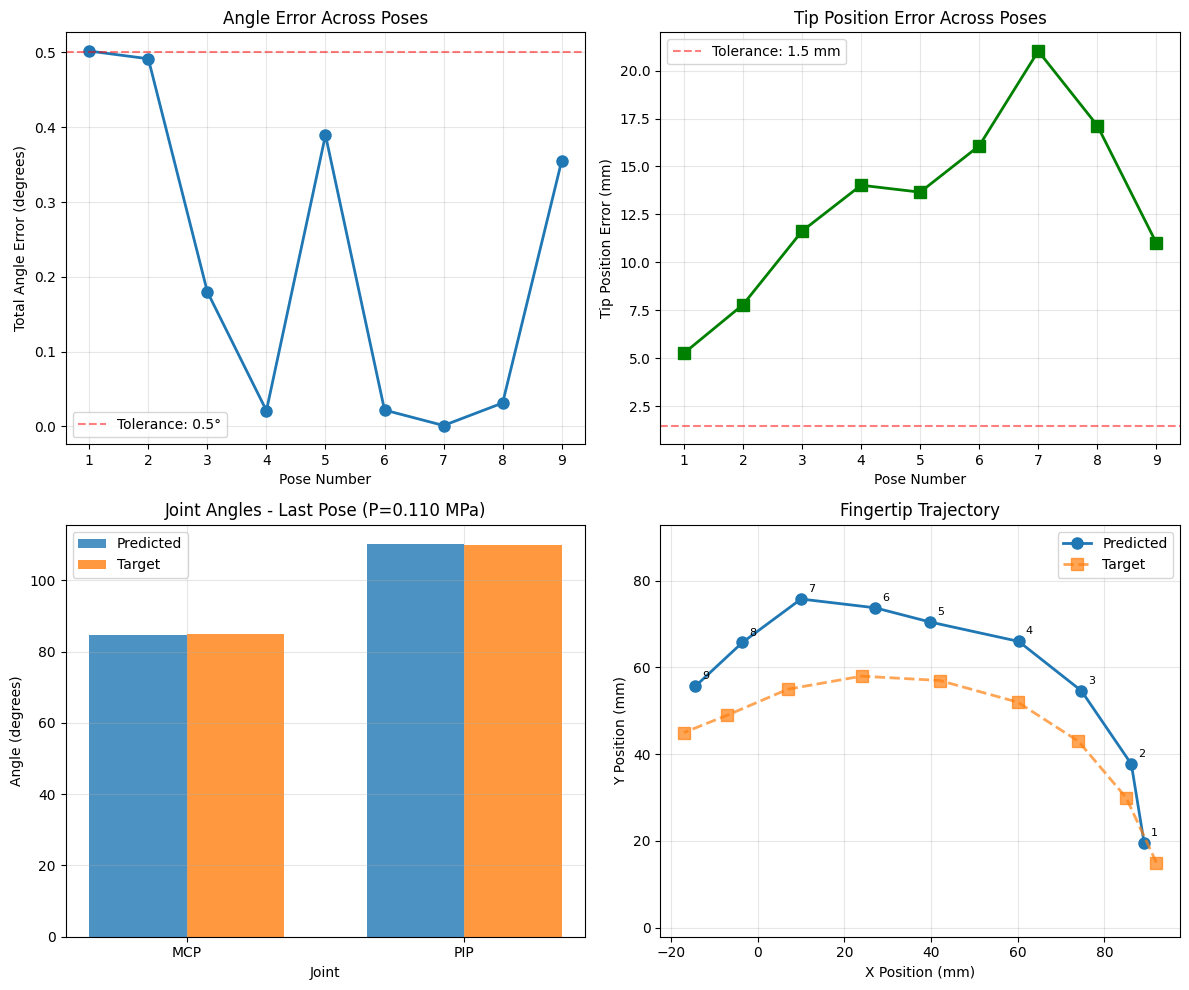


Optimization complete! Results and visualizations generated.


In [ ]:
# -------------------------
# === Visualization ===
# -------------------------
print("\n" + "="*80)
print("GENERATING VISUALIZATIONS")
print("="*80)

# Plot layout
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Angle errors
ax = axes[0, 0]
ax.plot(range(1, POSE_COUNT), angle_errs, 'o-', linewidth=2, markersize=8)
ax.axhline(y=ANGLE_TOL, color='r', linestyle='--', alpha=0.5, label=f'Tolerance: {ANGLE_TOL}°')
ax.set_xlabel('Pose Number')
ax.set_ylabel('Total Angle Error (degrees)')
ax.set_title('Angle Error Across Poses')
ax.grid(True, alpha=0.3)
ax.legend()

# 2. Tip errors
ax = axes[0, 1]
ax.plot(range(1, POSE_COUNT), tip_errs, 's-', color='green', linewidth=2, markersize=8)
ax.axhline(y=TIP_TOL, color='r', linestyle='--', alpha=0.5, label=f'Tolerance: {TIP_TOL} mm')
ax.set_xlabel('Pose Number')
ax.set_ylabel('Tip Position Error (mm)')
ax.set_title('Tip Position Error Across Poses')
ax.grid(True, alpha=0.3)
ax.legend()

# 3. Last pose angle comparison (only MCP & PIP)
ax = axes[1, 0]
last_idx = POSE_COUNT - 1
act = best_actuators[last_idx - 1]
segs = [act[i*8:(i+1)*8] for i in range(2)]  # 2 actuators
P_last = PRESSURE_SCHEDULE[last_idx]

predicted_angles = []
for seg in segs:
    inp = np.array(list(seg) + [P_last]).reshape(1, -1)
    try:
        th = float(model.predict_values(inp)[0][0])
    except:
        _, L_seg, n_seg, ch_h, ch_w, _, ch_len, ch_channel = seg
        th = compute_theta(P_last, E_USER, N_LUD, ch_w, ch_h, L_seg)
    predicted_angles.append(th)

joints = ['MCP', 'PIP']
x_pos = np.arange(len(joints))
width = 0.35

bars1 = ax.bar(x_pos - width/2, predicted_angles, width, label='Predicted', alpha=0.8)
bars2 = ax.bar(x_pos + width/2, TARGET_ANGLES[last_idx], width, label='Target', alpha=0.8)

ax.set_xlabel('Joint')
ax.set_ylabel('Angle (degrees)')
ax.set_title(f'Joint Angles - Last Pose (P={P_last:.3f} MPa)')
ax.set_xticks(x_pos)
ax.set_xticklabels(joints)
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Tip position trajectory (2-link FK)
ax = axes[1, 1]
predicted_tips_x = []
predicted_tips_y = []

for i in range(1, POSE_COUNT):
    act = best_actuators[i-1]
    bone = best_bones[i-1]
    segs = [act[j*8:(j+1)*8] for j in range(2)]
    L1, L2 = act[1], act[9]      # actuator segment lengths
    L11, L12 = bone              # bone lengths
    P_pose = PRESSURE_SCHEDULE[i]

    thetas = []
    for seg in segs:
        inp = np.array(list(seg) + [P_pose]).reshape(1, -1)
        try:
            th = float(model.predict_values(inp)[0][0])
        except:
            _, L_seg, n_seg, ch_h, ch_w, _, ch_len, ch_channel = seg
            th = compute_theta(P_pose, E_USER, N_LUD, ch_w, ch_h, L_seg)
        thetas.append(th)

    # 2-link tip position computation
    x_pred, y_pred = compute_tip_position(thetas[0], thetas[1],
                                          L11, L12, L1, L2)
    predicted_tips_x.append(x_pred)
    predicted_tips_y.append(y_pred)

ax.plot(predicted_tips_x, predicted_tips_y, 'o-', label='Predicted', markersize=8, linewidth=2)
ax.plot(TARGET_POSITIONS[1:, 0], TARGET_POSITIONS[1:, 1], 's--',
        label='Target', markersize=8, linewidth=2, alpha=0.7)

# Add pose numbers
for i, (x, y) in enumerate(zip(predicted_tips_x, predicted_tips_y)):
    ax.annotate(str(i+1), (x, y), textcoords="offset points",
                xytext=(5, 5), fontsize=8)

ax.set_xlabel('X Position (mm)')
ax.set_ylabel('Y Position (mm)')
ax.set_title('Fingertip Trajectory')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axis('equal')

plt.tight_layout()
plt.show()

print("\nOptimization complete! Results and visualizations generated.")





___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000951
   
   Prediction time/pt. (sec) :  0.0000951
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000634
   
   Prediction time/pt. (sec) :  0.0000634
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000551
   
   Prediction time/pt. (sec) :  0.0000551
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000515
   
   Prediction time/pt. (sec) :  0.0000515
   
________________________________________________

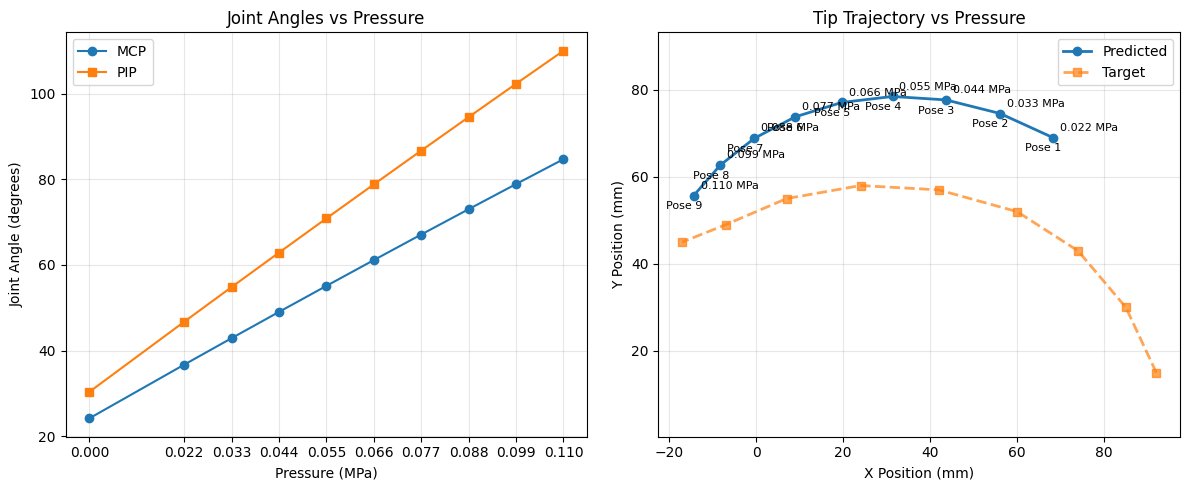

In [ ]:
# -------------------------
# Additional: Behavior vs Pressure for final design (fixed & annotated)
# -------------------------

# Use your actual pressures (including 0.0 for rest pose if you want)
pressures = np.array(PRESSURE_SCHEDULE)  # keeps your real schedule

mcp_vals, pip_vals, tip_x, tip_y = [], [], [], []

# Final design from the last pose
last_idx = POSE_COUNT - 1
segs  = [best_actuators[last_idx - 1][i*8:(i+1)*8] for i in range(2)]
bones = best_bones[last_idx - 1]

for P in pressures:
    # Predict joint angles
    thetas = []
    for seg in segs:
        inp = np.array(list(seg) + [P]).reshape(1, -1)
        try:
            th = float(model.predict_values(inp)[0][0])
        except:
            _, L_seg, n_seg, ch_h, ch_w, _, ch_len, ch_channel = seg
            th = compute_theta(P, E_USER, N_LUD, ch_w, ch_h, L_seg)
        thetas.append(th)

    mcp_vals.append(thetas[0])
    pip_vals.append(thetas[1])

    # Tip coordinates
    x_pred, y_pred = compute_tip_position(
        thetas[0], thetas[1],
        bones[0], bones[1],
        segs[0][1], segs[1][1]
    )
    tip_x.append(x_pred)
    tip_y.append(y_pred)

fig2, ax2 = plt.subplots(1, 2, figsize=(12, 5))

# --- Left: Joint angles vs actual pressures ---
ax2[0].plot(pressures, mcp_vals, 'o-', label='MCP')
ax2[0].plot(pressures, pip_vals, 's-', label='PIP')
ax2[0].set_xlabel('Pressure (MPa)')
ax2[0].set_ylabel('Joint Angle (degrees)')
ax2[0].set_title('Joint Angles vs Pressure')
ax2[0].legend()
ax2[0].grid(True, alpha=0.3)
ax2[0].set_xticks(pressures)  # show your exact pressures

# --- Right: Tip trajectory with target curve & annotations ---
ax2[1].plot(tip_x[1:], tip_y[1:], 'o-', label='Predicted', linewidth=2)

# Overlay target curve (skip Pose 0)
ax2[1].plot(TARGET_POSITIONS[1:, 0], TARGET_POSITIONS[1:, 1], 's--',
            label='Target', alpha=0.7, linewidth=2)

# Annotate predicted points (start Pose count from 1)
for k, (x, y, P) in enumerate(zip(tip_x[1:], tip_y[1:], pressures[1:]), start=1):
    ax2[1].annotate(f"{P:.3f} MPa", (x, y), textcoords="offset points",
                    xytext=(5, 5), fontsize=8)
    ax2[1].annotate(f"Pose {k}", (x, y), textcoords="offset points",
                    xytext=(-20, -10), fontsize=8)

ax2[1].set_xlabel('X Position (mm)')
ax2[1].set_ylabel('Y Position (mm)')
ax2[1].set_title('Tip Trajectory vs Pressure')
ax2[1].legend()
ax2[1].grid(True, alpha=0.3)
ax2[1].axis('equal')

plt.tight_layout()
plt.show()
